In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
import pandas as pd
import datetime

import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data
from models.ihme.dataloader import get_dataframes_cached
from data.processing import get_data, get_all_district_data, get_concat_data

from main.seir.losses import Loss_Calculator
from main.seir.fitting import get_variable_param_ranges, data_setup, run_cycle
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report
from recovs import rsingle_fitting_cycle, smooth_using_active

## Load Covid19india Data

In [24]:
dataframes = get_dataframes_cached()

In [25]:
predictions_dict = {}

## Select Districts to fit on

In [26]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

In [55]:
# df_district, df_district_raw_data = get_all_district_data(
#         dataframes, state='Maharashtra', district='Mumbai', 
#         data_from_tracker=True, data_format=None, filename=None)
df_district = get_concat_data(dataframes, state='Maharashtra', district='Mumbai', concat=True)

60 deaths and 1148 recoveries in Maharashtra with unknown district


In [56]:
df_district[-10:]

,date,total_infected,hospitalised,deceased,recovered,district,state
73,2020-05-23,28817,21772,949,6096,Mumbai,Maharashtra
74,2020-05-24,30542,22471,988,7083,Mumbai,Maharashtra
75,2020-05-25,31972,23863,1026,7083,Mumbai,Maharashtra
76,2020-05-26,32974,23896,1065,8013,Mumbai,Maharashtra
77,2020-05-27,34018,24908,1097,8013,Mumbai,Maharashtra
78,2020-05-28,35485,25700,1135,8650,Mumbai,Maharashtra
79,2020-05-29,35485,25700,1135,8650,Mumbai,Maharashtra
80,2020-05-30,38442,20851,1227,16364,Mumbai,Maharashtra
81,2020-05-31,38442,20851,1227,16364,Mumbai,Maharashtra
82,2020-06-01,41099,22795,1319,16985,Mumbai,Maharashtra


In [90]:
# df_district[44:][-10:]
new_df_district = smooth_using_active(df_district, last_n_days=15)
new_df_district['new_ti'] = new_df_district['n_recovered'] + new_df_district['n_hospitalised']
new_df_district['orig_ti'] = new_df_district['recovered'] + new_df_district['hospitalised']
new_df_district['new_diff'] = new_df_district['total_infected'] - new_df_district['new_ti'] 
new_df_district['orig_diff'] = new_df_district['total_infected'] - new_df_district['orig_ti']
print (new_df_district[['date', 'total_infected', 'new_ti', 'orig_ti', 'new_diff', 'orig_diff']][-25:])
# # new_df_district[-10:]
# # print (new_df_district['n_recovered'] - new_df_district['recovered'])
# # print (new_df_district['n_hospitalised'] - new_df_district['hospitalised'])
# new_df_district['recovered'] = new_df_district['n_recovered']
# new_df_district['hospitalised'] = new_df_district['n_hospitalised']
# del new_df_district['n_recovered']
# del new_df_district['n_hospitalised']
# new_df_district

7714 7715.0
-4849 -4849.0
         date  total_infected  new_ti  orig_ti  new_diff  orig_diff
58 2020-05-08           12142   11680    11680       462        462
59 2020-05-09           12864   12375    12375       489        489
60 2020-05-10           13739   13231    13231       508        508
61 2020-05-11           14521   13993    13993       528        528
62 2020-05-12           14947   14391    14391       556        556
63 2020-05-13           15747   15191    15191       556        556
64 2020-05-14           16738   16117    16117       621        621
65 2020-05-15           17671   17016    17016       655        655
66 2020-05-16           18555   18210    17859       345        696
67 2020-05-17           20150   19535    19416       615        734
68 2020-05-18           21335   20578    20578       757        757
69 2020-05-19           21335   20887    20578       448        757
70 2020-05-20           24118   23485    23277       633        841
71 2020-05-21         

## Perform M1 and M2 fits

In [74]:
smoothfunc = smooth_using_active
ndays=7


fitting to data with "train_on_val" set to False ..
60 deaths and 1148 recoveries in Maharashtra with unknown district
7714 7714.0
-4849 -4849.0
splitting data ..
splitting data ..
train
          date  total_infected  hospitalised  deceased  recovered district  \
25 2020-05-21         25404.2       19480.2     867.6     5131.2   Mumbai   
26 2020-05-22         27245.6       20451.4     913.8     6046.0   Mumbai   
27 2020-05-23         28816.4       21301.8     950.8     6810.4   Mumbai   
28 2020-05-24         30311.2       22023.0     987.4     7591.4   Mumbai   
29 2020-05-25         31664.6       22749.6    1025.0     8263.4   Mumbai   

          state  
25  Maharashtra  
26  Maharashtra  
27  Maharashtra  
28  Maharashtra  
29  Maharashtra  
val
         date  total_infected  hospitalised  deceased  recovered district  \
0 2020-05-26         32998.2       23488.0    1062.2     8849.4   Mumbai   
1 2020-05-27         33986.8       24123.6    1091.6     9179.0   Mumbai   
2 2020-0

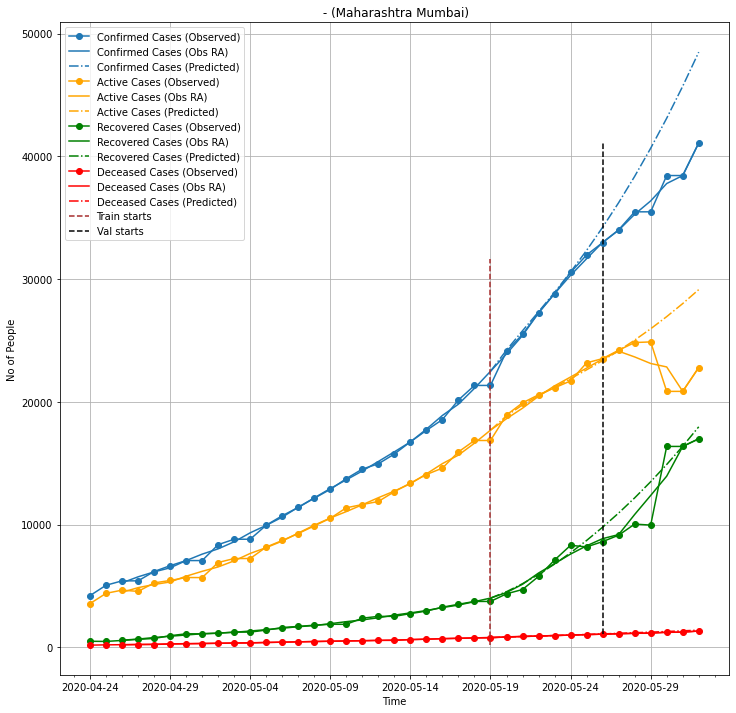

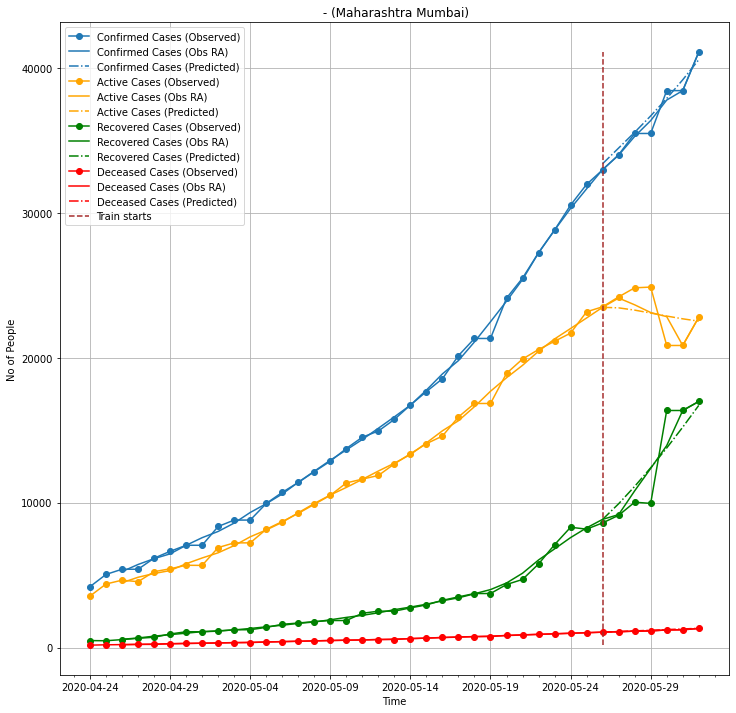

In [75]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = rsingle_fitting_cycle(smoothfunc,
        dataframes, state, district, train_period=7, val_period=7,
        n_days_back_smooth=ndays,
        data_from_tracker=True, initialisation='intermediate', num_evals=700,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = rsingle_fitting_cycle(smoothfunc,
        dataframes, state, district, train_period=7, val_period=0, num_evals=700,
        n_days_back_smooth=ndays,
        train_on_val=True, data_from_tracker=True, initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [71]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         2.15           1.26     1.42      3.38   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai        10.96           6.82     5.41      16.3

### M2 Loss

In [72]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai          5.8           1.29     1.71        11

In [80]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['ax']

AttributeError: 'AxesSubplot' object has no attribute 'keys'

## Plot Forecasts

getting forecasts ..


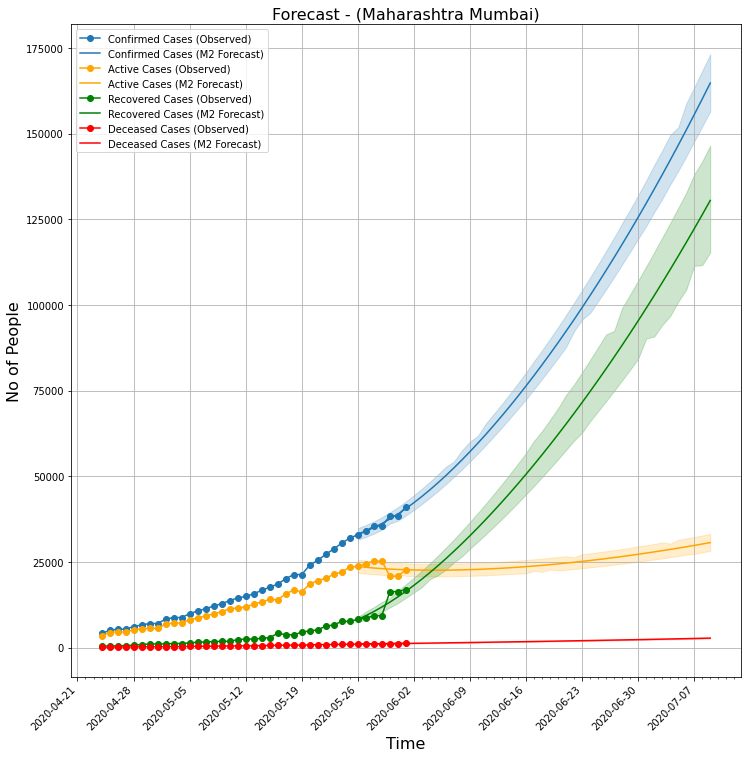

In [73]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

In [37]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [38]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [39]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))